In [ ]:
!pip install fastai==2.4

In [ ]:
conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c conda-forge

Do not Forget to reset the kernel

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
from keras import models

# 1. Data particioning:
choosing 1000 random images (80% for traing and 20% for testing)


To download cocodataset:

In [2]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [3]:
#If you want to use coco dataset
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") 
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_00, replace=False) 
rand_idxs = np.random.permutation(10_00)
train_idxs = rand_idxs[:800] 
val_idxs = rand_idxs[800:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

800 200


run below code and change path to your dataset If you want to use your own dataset

In [ ]:

use_colab = False
if use_colab == True:
    path = coco_path
else:
    path = "/content/data/cat-dog"
    
paths = glob.glob(path + "/*.jpg")
np.random.seed(123)
paths_subset = np.random.choice(paths, 4_0, replace=False)
rand_idxs = np.random.permutation(4_0)
train_idxs = rand_idxs[:30] 
val_idxs = rand_idxs[30:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

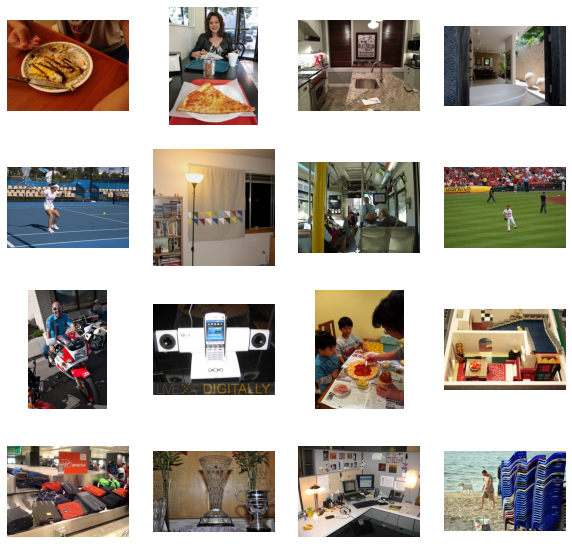

In [4]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# Data augmentation:
- tranforming our images from RGB color space to Lab color space.(It is easier to predict two channels)
- horizontally flipping images.
- recizing image to 256*256 (so we have to use GAN-256 as the generator)


In [5]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), 
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)



batch size is consider 16 (it can be considered as the hyperparameter to find the optimal value)

In [6]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

L shape is (16,1,256,256) which means number of batch size,number of channels, size, size.

ab shape is (16,2,256,256)

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
50 13


# 3.Generator:
using a Unet back bone for generator

In [8]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

# 4.Discriminator:
batch discriminator is used as the discriminator instead of vanilla. 

In [9]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

# 5.GAN loss:
conditional GAN loss and L1(MAE) are used as the generator loss.

In [11]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# 6.initial weights:
initial weights has been chosen randomly here but we can consider it as hyper parameter to improve the model

In [12]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [13]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [14]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
fid_lst = []   
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

 
    # scale an array of images to a new size
    def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)
 
    # calculate frechet inception distance
    def calculate_fid(model, images1, images2):
        # calculate activations
        act1 = model.predict(images1)
        act2 = model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = numpy.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid
 
    # prepare the inception v3 model
    model1 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images1 = real_imgs
    images2 = fake_imgs
    print('Loaded', images1.shape, images2.shape)
    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    print('Scaled', images1.shape, images2.shape)
    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    # calculate fid
    fid = calculate_fid(model1, images1, images2)
    fid_lst.append(fid)
    print('FID: %.3f' % fid)   
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        if loss_name=='loss_G':
            loss_G_list.append(loss_meter.avg)
        if loss_name=='loss_D':
            acc_D_list.append(100-loss_meter.avg)
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        

# 7.Train the model:

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/5
Iteration 50/50
loss_D_fake: 0.62335
loss_D_real: 0.66060
loss_D: 0.64198
loss_G_GAN: 1.07358
loss_G_L1: 9.82258
loss_G: 10.89617


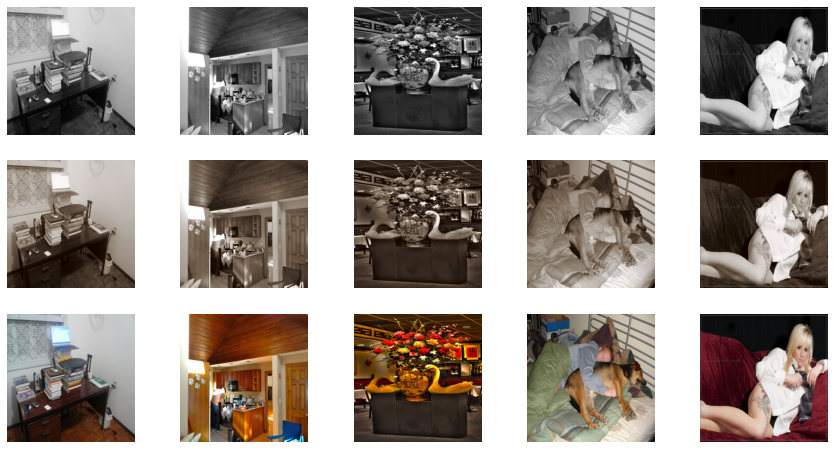

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 219ms/step
FID: 0.090


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/5
Iteration 50/50
loss_D_fake: 0.45088
loss_D_real: 0.46570
loss_D: 0.45829
loss_G_GAN: 1.50589
loss_G_L1: 8.97033
loss_G: 10.47623


/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


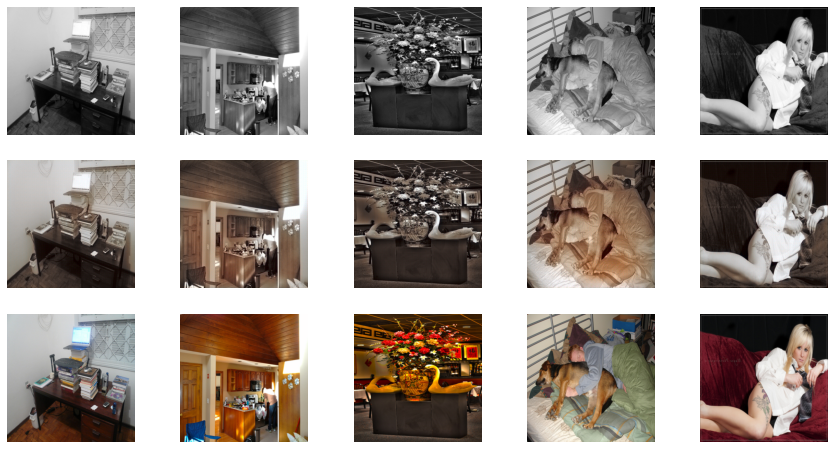

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 222ms/step
FID: 0.091


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3/5
Iteration 50/50
loss_D_fake: 0.45260
loss_D_real: 0.46963
loss_D: 0.46112
loss_G_GAN: 1.71731
loss_G_L1: 9.23873
loss_G: 10.95603


/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 55 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


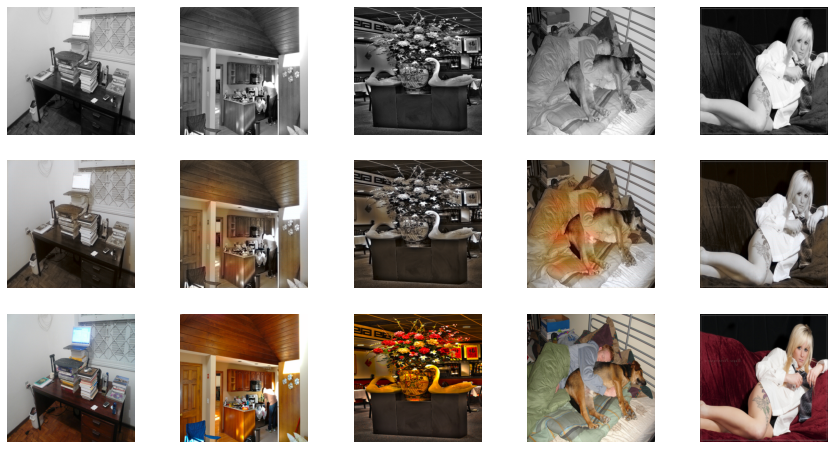

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 216ms/step
FID: 0.094


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4/5
Iteration 50/50
loss_D_fake: 0.48567
loss_D_real: 0.47800
loss_D: 0.48183
loss_G_GAN: 1.52008
loss_G_L1: 9.78541
loss_G: 11.30549


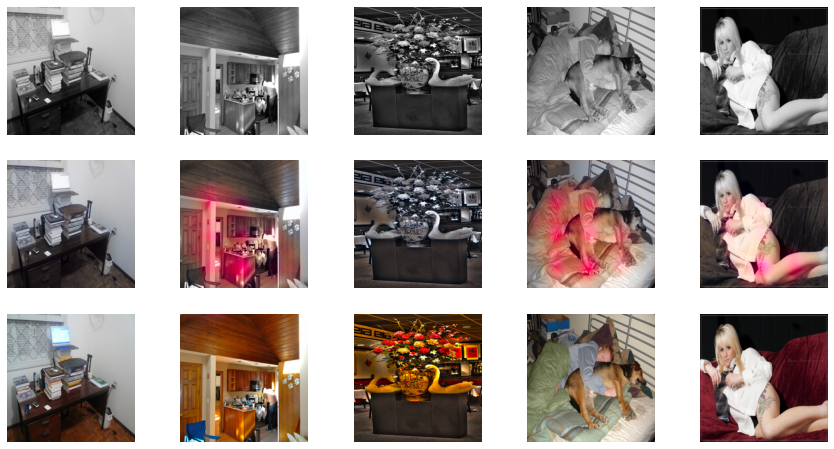

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 222ms/step
FID: 0.112


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/5
Iteration 50/50
loss_D_fake: 0.38773
loss_D_real: 0.40076
loss_D: 0.39424
loss_G_GAN: 1.94177
loss_G_L1: 10.02129
loss_G: 11.96306


/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


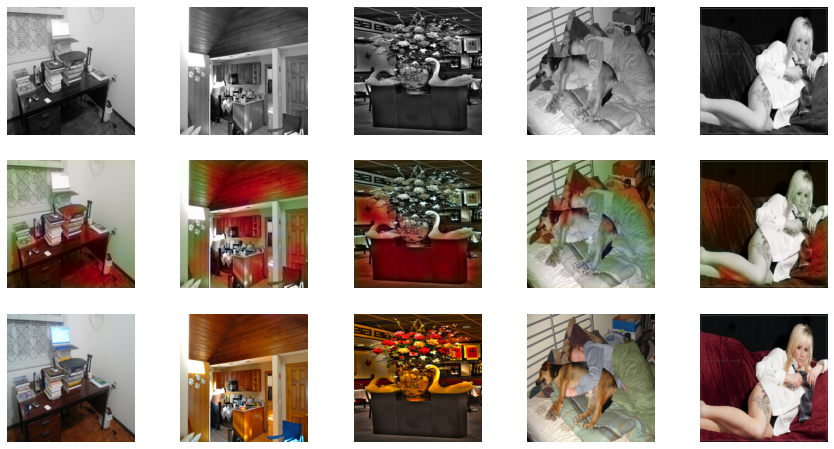

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 227ms/step
FID: 0.095


In [16]:
loss_G_list=[]
acc_D_list=[]
def train_model(model, train_dl, epochs, display_every=50):
    data = next(iter(val_dl)) 
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() 
        i = 0                                  
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) 
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) 
                visualize(model, data, save=False) 

model = MainModel()
train_model(model, train_dl, 5,50)#100 is optimal epochs

# 8.plotting loss, accuracy and FID

[0.08957740356996731, 0.09079629935391434, 0.0938461564600489, 0.1120999856449322, 0.09478035437555479]
[10.896168813705444, 10.476226577758789, 10.956033210754395, 11.305491619110107, 11.963055839538574]
[99.35802485585212, 99.54170958697796, 99.53888112902641, 99.51816594719887, 99.6057584105432]


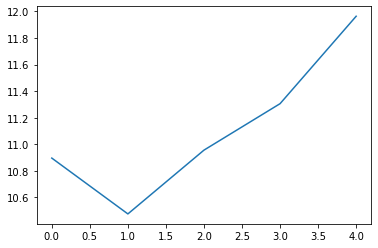

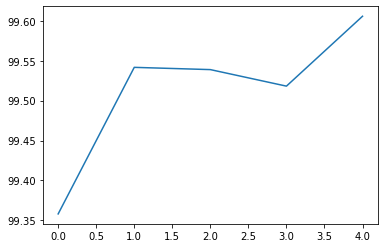

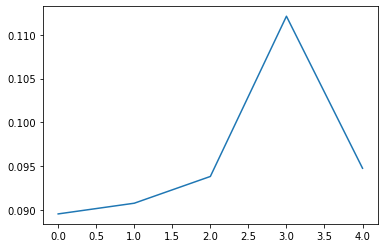

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
print(fid_lst)
print(loss_G_list)
print(acc_D_list)
plt.plot(loss_G_list)
plt.show()
plt.plot(acc_D_list)
plt.show()
plt.plot(fid_lst)
plt.show()

# 9.try the 2nd generator(pretrained resnet)

In [18]:
#!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [19]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [21]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "res18-unet.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.10861


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08557


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.08464


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.08404


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.08366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.08316


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.08312


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.08287


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.08241


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.08220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.08199


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.08134


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.08195


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.08124


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.08057


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.08126


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.07968


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.07855


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.07767


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.07781


model initialized with norm initialization


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/5
Iteration 50/50
loss_D_fake: 0.69670
loss_D_real: 0.70196
loss_D: 0.69933
loss_G_GAN: 0.93860
loss_G_L1: 8.91990
loss_G: 9.85850


/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 36808 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 11153 pixels
  return func(*args, **kwargs)


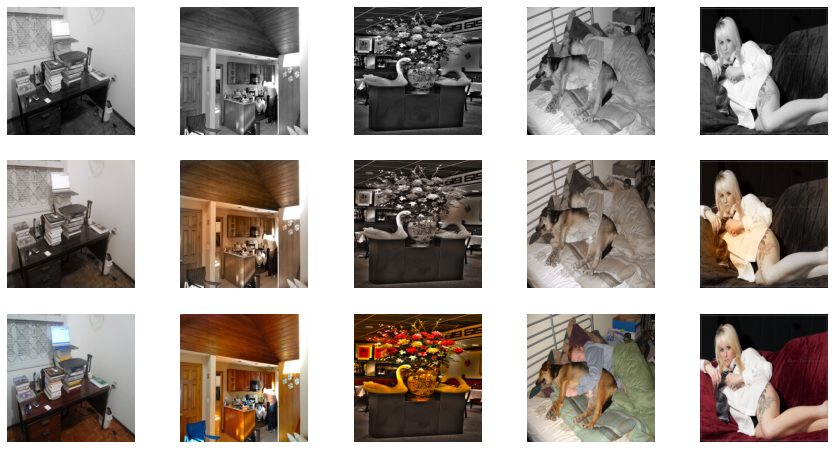

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 256ms/step
FID: 0.240


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 2/5
Iteration 50/50
loss_D_fake: 0.36113
loss_D_real: 0.40651
loss_D: 0.38382
loss_G_GAN: 1.68258
loss_G_L1: 8.77811
loss_G: 10.46069


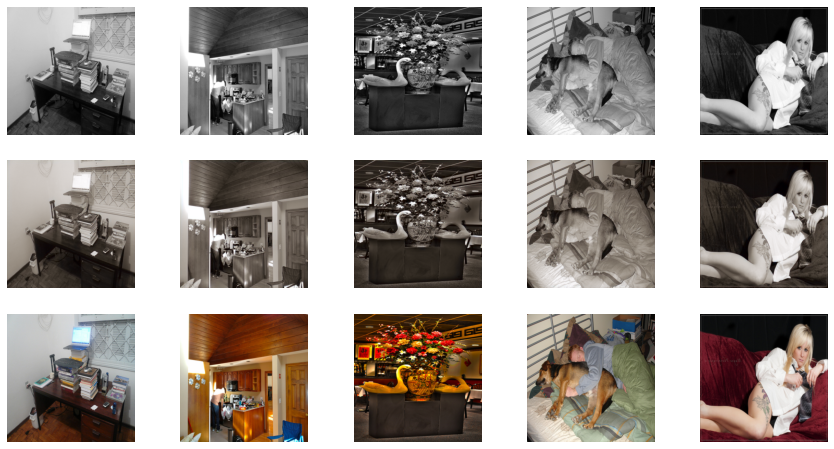

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 239ms/step
FID: 0.092


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 3/5
Iteration 50/50
loss_D_fake: 0.22639
loss_D_real: 0.23633
loss_D: 0.23136
loss_G_GAN: 2.53129
loss_G_L1: 8.75832
loss_G: 11.28961


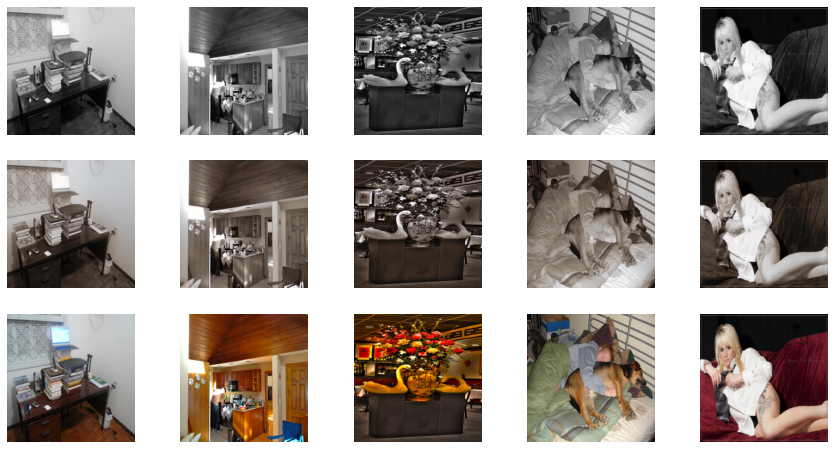

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 238ms/step
FID: 0.084


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 4/5
Iteration 50/50
loss_D_fake: 0.20051
loss_D_real: 0.18296
loss_D: 0.19173
loss_G_GAN: 2.90439
loss_G_L1: 8.84327
loss_G: 11.74766


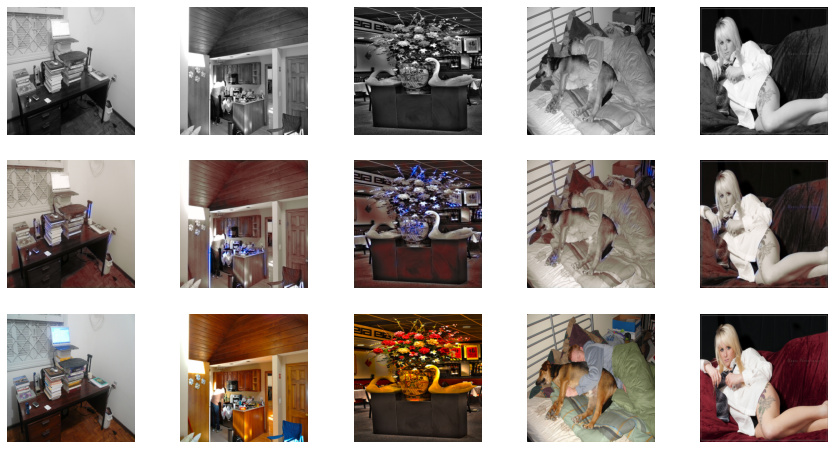

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 256ms/step
FID: 0.118


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/5
Iteration 50/50
loss_D_fake: 0.43751
loss_D_real: 0.43084
loss_D: 0.43418
loss_G_GAN: 1.94491
loss_G_L1: 9.46871
loss_G: 11.41362


/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1438 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 328 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 113 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 154 pixels
  return func(*args, **kwargs)
/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1178 pixels
  return func(*args, **kwargs)


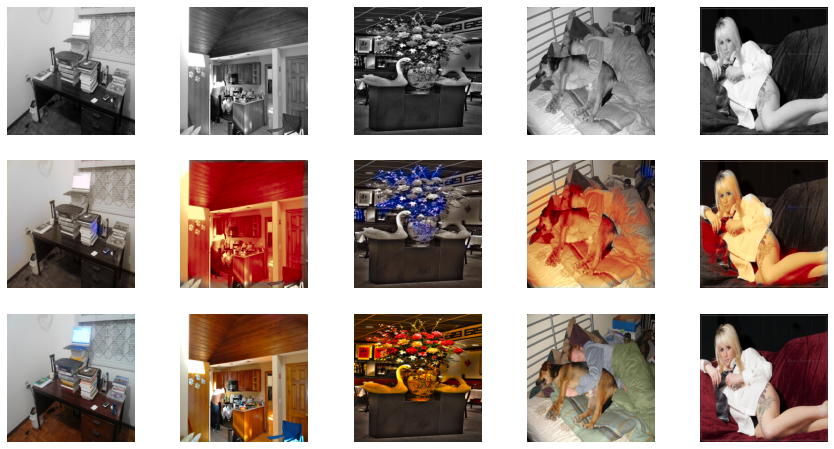

Loaded (16, 256, 256, 3) (16, 256, 256, 3)
Scaled (16, 299, 299, 3) (16, 299, 299, 3)
1/1 [==============================] - 0s 223ms/step
FID: 0.102


In [22]:
loss_G_list=[]
acc_D_list=[]
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 5,50)#100 is optimal epochs

# 10.plotting loss, accuracy and FID

[0.08957740356996731, 0.09079629935391434, 0.0938461564600489, 0.1120999856449322, 0.09478035437555479, 0.2404716488041881, 0.09150558790858443, 0.08379007853308196, 0.11835419157741336, 0.10245819938137285]
[9.858504037857056, 10.460686902999878, 11.289609870910645, 11.747656326293946, 11.413615474700928]
[99.30066940069199, 99.61617889255285, 99.76864045694471, 99.80826779179274, 99.56582386180759]


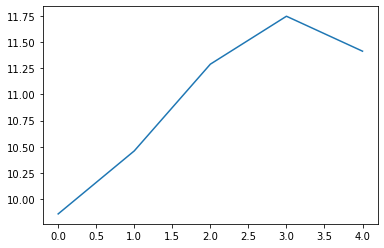

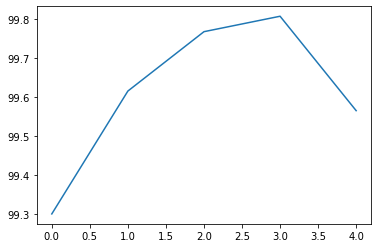

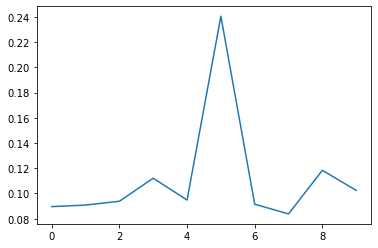

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
print(fid_lst)
print(loss_G_list)
print(acc_D_list)
plt.plot(loss_G_list)
plt.show()
plt.plot(acc_D_list)
plt.show()
plt.plot(fid_lst)
plt.show()

In [24]:
def visualize_test(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(3, 1, 1)
    ax.imshow(L[0][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 1, 1+1)
    ax.imshow(fake_imgs[0])
    ax.axis("off")
    ax = plt.subplot(3, 1, 1+2)
    ax.imshow(real_imgs[0])
    ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

# 11. testing model on test data:

In [25]:
path='path of test data'    
photo_path = glob.glob(path + "/*.jpg") 
test_dl = make_dataloaders(paths=photo_path, split='val')

/home/omidlavakhamseh/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [26]:
for data in tqdm(test_dl):
      visualize_test(model, data, save=False) 

0it [00:00, ?it/s]